# Surface Codes, Persistent Homology, and Phase Transitions

In the paper [Optimal Resources for Topological 2D Stabilizer Codes: Comparative Study](https://arxiv.org/abs/quant-ph/0703272) the following image can be found:

<img src="error_string.png" alt= “error_string” width="750" height="500">

We would like to study error strings, both closed (as in the image above of the red loop), and open. Error strings are represented by a path in the Riemann surface, cutting through and connecting edge qubits where an error has occurred. We would like to compute persistent homology of such states and determine what persistent topological features might be present in the presence of an error. We would also like to see if there is any connection to phase transitions as studied in [Persistent Homology of Entanglement](https://arxiv.org/abs/2110.10214). 

In [1]:
pip install cirq -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cirq
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
import networkx as nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display

In [4]:
import cirq
import numpy as np
from typing import Tuple
import networkx as nx

# from qiskit import
# from src import SurfaceCodeGraph


class CirqSurfaceCodeCircuit():

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        # super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qubits = [cirq.NamedQubit(str(node)) for node in self.scgraph.code_graph.nodes]
        self.circuit = cirq.Circuit()

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

        for cycle in self.sigma:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

        for cycle in self.phi:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

    def draw_circuit(self, render=''):
        # if render == 'mpl':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw('mpl')

        # if render == 'plain':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw()

        if render == '':
            print(self.circuit)

    def x_measurement(self, qubit):
        """Measure 'qubit' in the X-basis
        :param qubit: a name to designate a cirq.NamedQubit(str(qubit))
        :return None
        """
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.measure(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))

    def star_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CX gates to surrounding qubits of a star then measures star qubit in X-basis
        :param vertex:
        :return:  self.circ, self.scgraph, self.node_info
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CNOT(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))
        self.x_measurement(vertex)

    def face_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CZ gates to surrounding qubits on the boundary of a face then measures face qubit in X-basis
        :param vertex:
        :return:
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CZ(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))

        self.x_measurement(vertex)

    def X_1_chain(self, edges):
        """
        Pauli product X operator for arbitrary 1-cochain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(edge))))

    def Z_1_chain(self, edges):
        """
        Pauli product Z operator for arbitrary 1-chain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(edge))))

    def product_Z(self, faces):
        """
        Pauli product Z operator for arbitrary 2-chain boundary
        """

        boundary_nodes = self.scgraph.del_2(faces)
        for node in boundary_nodes:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(node))))

    def product_X(self, stars):
        """
        Pauli product X operator for arbitrary 0-cochain coboundary
        """
        coboundary_nodes = self.scgraph.delta_1(stars)
        for node in coboundary_nodes:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(node))))



    def draw_graph(self, node_type='', layout=''):
        if layout == 'spring':
            pos = nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos = nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos = nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos = nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos = nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos = nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos = nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

The following code constructs a surface code corresponding to the following graph, 

<img src="dessin_graph.png" alt= “error_string” width="750" height="500">


embedded in a torus (Riemann surface) as follows (with x = (1,2,3) and y = (4,5,6) and edges unlabeled),

<img src="dessin.png" alt= “error_string” width="750" height="500">


In [10]:
sigma = ((0,1,2),(3,4,5))
alpha = ((0,3),(1,4),(2,5))
SCC = CirqSurfaceCodeCircuit(sigma, alpha)

In [11]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 5, 1, 3, 2, 4): ───H───

(3, 4, 5): ────────────H───


Create a $1$-chain of errors (corresponding to some subset of edge qubits given $\alpha$). Here we create a phase error given by a string on the Riemann surface connecting the the qubit on edge node $(1,4)$ and the edge node $(2,5)$. 

In [12]:
SCC.Z_1_chain([(1,4), (2,5)])
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 5, 1, 3, 2, 4): ───H───

(1, 4): ───────────────Z───

(2, 5): ───────────────Z───

(3, 4, 5): ────────────H───


In [14]:
# Add star syndrome measurements
for vertex in SCC.sigma_dict:
    SCC.star_syndrome_measure(vertex)

# Add face syndrome measurements
for vertex in SCC.phi_dict:
    SCC.face_syndrome_measure(vertex)

# Draw the circuit
SCC.draw_circuit()

                               ┌──┐   ┌──┐
(0, 1, 2): ────────────H───@────@──────@─────H───M───H───────────
                           │    │      │
(0, 3): ───────────────────X────┼X─────┼@────────────────────────
                                ││     ││
(0, 5, 1, 3, 2, 4): ───H────────┼┼─────┼@────@───@───H───M───H───
                                ││     │     │   │
(1, 4): ───────────────Z────────X┼─────┼X────@───┼───────────────
                                 │     ││        │
(2, 5): ───────────────Z─────────┼─────X┼────X───@───────────────
                                 │      │    │
(3, 4, 5): ────────────H─────────@──────@────@───H───M───H───────
                               └──┘   └──┘


In [15]:
import numpy as np
from qiskit.quantum_info import partial_trace, entropy

def compute_inverse_mutual_information(rho):
    """
    Computes the inverse quantum mutual information for every pair of qubits in the input density matrix.

    Args:
        rho (numpy.ndarray): a 2^n x 2^n density matrix representing the state of n qubits.

    Returns:
        numpy.ndarray: an n x n matrix of inverse quantum mutual information values, where element i,j gives the inverse
        mutual information between qubits i and j.
    """
    # Determine the number of qubits n from the shape of rho.
    n = int(np.log2(rho.shape[0]))

    # Create an empty n x n matrix to store the inverse mutual information.
    inverse_mutual_information_matrix = np.zeros((n, n))

    # Loop over all pairs of qubits (i, j).
    for i in range(n):
        for j in range(i+1, n):

            # Define the indices of the qubits to trace out.
            trace_indices = [k for k in range(n) if k != i and k != j]

            # Trace out the other qubits to obtain the reduced density matrix of qubits i and j.
            rho_ij = partial_trace(rho, trace_indices)

            # Compute the von Neumann entropy of the reduced density matrix of qubit i.
            entropy_i = entropy(partial_trace(rho_ij, [1]))

            # Compute the von Neumann entropy of the reduced density matrix of qubit j.
            entropy_j = entropy(partial_trace(rho_ij, [0]))

            # Compute the mutual information between qubits i and j.
            qmi = entropy_i + entropy_j - entropy(rho_ij)

            # Compute the inverse mutual information between qubits i and j.
            inverse_mutual_information_matrix[i, j] = 2 * np.log(2) - qmi

    # Copy the upper triangular part of the matrix to the lower triangular part.
    inverse_mutual_information_matrix += inverse_mutual_information_matrix.T - np.diag(inverse_mutual_information_matrix.diagonal())

    return inverse_mutual_information_matrix

In [16]:
# Simulate the circuit and get the density matrix
simulator = cirq.DensityMatrixSimulator()
result = simulator.simulate(SCC.circuit)
density_matrix = result.final_density_matrix

# Compute the inverse mutual information matrix
inverse_mutual_information_matrix = compute_inverse_mutual_information(density_matrix)

print(inverse_mutual_information_matrix)

[[0.         1.38629333 1.38629333 1.38629333 1.38629333 1.38629333]
 [1.38629333 0.         1.38629333 1.38629333 1.38629333 1.38629333]
 [1.38629333 1.38629333 0.         1.38629333 1.38629333 1.38629333]
 [1.38629333 1.38629333 1.38629333 0.         1.38629333 1.38629333]
 [1.38629333 1.38629333 1.38629333 1.38629333 0.         1.38629333]
 [1.38629333 1.38629333 1.38629333 1.38629333 1.38629333 0.        ]]


In [17]:
import gudhi as gd

def persistent_homology(qmi_distance_matrix, dimension=1):
    """
    Computes the persistent homology for the QMI distance matrix.

    Args:
        qmi_distance_matrix (numpy.ndarray): An n x n QMI distance matrix.
        dimension (int): The maximum dimension for the simplices to compute persistent homology. Default is 1.

    Returns:
        list: A list of tuples representing the persistent homology. Each tuple contains two elements: the first
        element is the dimension of the feature, and the second element is a tuple representing the birth and death
        of the feature.
    """
    # Create a Rips complex from the QMI distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=qmi_distance_matrix, max_edge_length=np.inf)

    # Create a simplex tree from the Rips complex
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=dimension)

    # Compute the persistent homology
    persistence = simplex_tree.persistence()

    return persistence

In [19]:
qmi_distance_matrix = inverse_mutual_information_matrix
persistence = persistent_homology(qmi_distance_matrix)
persistence

[(0, (0.0, inf)),
 (0, (0.0, 1.3862933292243544)),
 (0, (0.0, 1.3862933292243544)),
 (0, (0.0, 1.3862933292243544)),
 (0, (0.0, 1.3862933292243544)),
 (0, (0.0, 1.3862933292243544))]

In [20]:
import matplotlib.pyplot as plt

def plot_persistence_diagram(persistence):
    """
    Plots the persistence diagram for the given persistent homology.

    Args:
        persistence (list): A list of tuples representing the persistent homology.
    """
    gd.plot_persistence_diagram(persistence)
    plt.show()


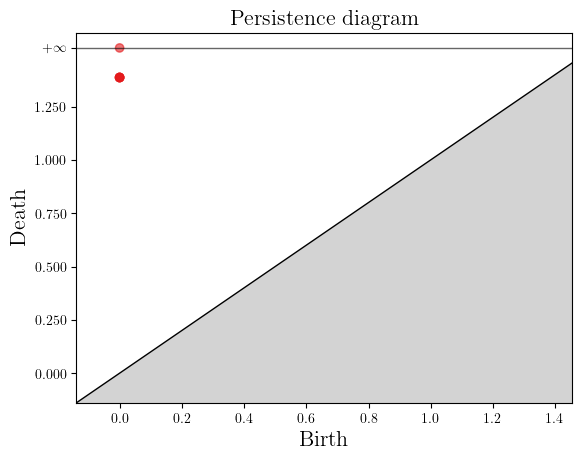

In [21]:
plot_persistence_diagram(persistence)